In [7]:
#importations and models
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import pandas as pd
import gensim.downloader as api
import numpy as np
import re
import gensim.downloader as api
from gensim.models import Word2Vec, FastText
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch
from transformers import BertTokenizer, BertModel

In [2]:

# Load GloVe embeddings from gensim's online repository
glove_word_vectors = api.load('glove-wiki-gigaword-100')

# Load Word2Vec embeddings from gensim's online repository
word2vec_model = api.load('word2vec-google-news-300')

# Load FastText embeddings from gensim's online repository
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

# Load BERT embeddings from Hugging Face's transformers library
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load BERT model from Hugging Face's transformers library
model = BertModel.from_pretrained('bert-base-uncased')

In [3]:
#original file upload
file_path = "mycards.json"
df = pd.read_json(file_path)

In [4]:
#cleaning

#Keep only English
df = df[df.lang == 'en']

#Keep only cards with playable layouts typelines and set types
layouts_to_exclude = ['token', 'art_series', 'double_faced_token', 'vanguard', 'emblem', 'planar', 'scheme']
df = df[~df.layout.isin(layouts_to_exclude)]


types_to_exclude = ['Hero', 'Conspiracy']
df = df[~df.type_line.isin(types_to_exclude)]

df=df[df.set_type != 'memorabilia']

sets_to_exclude = ['Unhinged', 'Unglued', 'Unstable']
df = df[~df['set_name'].isin(sets_to_exclude)]

#Keep only cards that are not basic lands
df = df[~((df.name == 'Plains') | (df.name == 'Island') | (df.name == 'Swamp') | (df.name == 'Mountain') | (df.name == 'Forest'))]

#two-sided
#all info stored in card_faces when name contains "//"
df_explode = df[df['name'].str.contains("//")]
# Explode the 'card_faces' column
df_explode = df_explode.explode('card_faces')
# Reset the index of the DataFrame
df_explode.reset_index(drop=True, inplace=True)
# Normalize the 'card_faces' column
df_normalized = pd.json_normalize(df_explode['card_faces'])
#if any of the image_uris are still in explode then take them
df_normalized['image_uris']=df_explode['image_uris']
# Fill 'image_uris' with 'image_uris.small' only where 'image_uris' is NaN
df_normalized['image_uris'] = df_normalized['image_uris'].fillna(df_normalized['image_uris.small'])
#keeping id numbers
df_normalized['id']=df_explode['id']

#keeping these
df_normalized['color_identity']=df_explode['color_identity']
df_normalized['colors']=df_explode['colors']
df_normalized['keywords']=df_explode['keywords']
df_normalized['legalities']=df_explode['legalities']

# Concatenate the normalized DataFrame with the original DataFrame
df = pd.concat([df, df_normalized], ignore_index=True)

#dropping duals after 2-sided split
df=df[~df.name.str.contains('//')]

#column dropping
cols_to_drop = np.array(df.columns[[0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 23, 27, 28, 29, 30, 31, 32, 33] + list(range(34, 85))])
df.drop(columns=cols_to_drop, inplace=True)
cols_to_drop = np.array(df.columns[list(range(13, 21))])
df.drop(columns=cols_to_drop, inplace=True)

#further cleaning
#filling in missing values
df['oracle_text'] = df['oracle_text'].fillna('')
#missing because not creature
df['power'] = df['power'].fillna(0)
df['toughness'] = df['toughness'].fillna(0)
#some are non-numeric so we need to create more NANs for non-numeric values
df['power'] = pd.to_numeric(df['power'], errors='coerce')
df['toughness'] = pd.to_numeric(df['toughness'], errors='coerce')
power_mean = df['power'].mean()
toughness_mean = df['toughness'].mean()
#have to fill in missing values for non-numeric special characters
df['power'].fillna(power_mean, inplace=True)
df['toughness'].fillna(toughness_mean, inplace=True)

#silly card
df=df[~df.name.str.contains('The Ultimate Nightmare of Wizards of the Coast® Customer Service')]
df = df.drop_duplicates(subset=['name'])

In [5]:
#getting mana counts for intensity calculations
def count_mana_symbols(text):
    counts = {'colorless': 0, 'U': 0, 'G': 0, 'W': 0, 'B': 0, 'R': 0, 'X': 0, 'C' :0, 'P':0, 'S':0}
    pattern = r'{([^}]*)}'
    mana_symbols = re.findall(pattern, text)
    for symbol in mana_symbols:
        if symbol.isdigit():
            counts['colorless'] += int(symbol)
        elif '/' in symbol:
            colors = symbol.split('/')
            for color in colors:
                if color in counts:
                    counts[color] += 0.5
        elif symbol in counts:
            counts[symbol] += 1
        else:
            print(f"Unexpected symbol: {symbol}")
    
    return counts
df = df.join(df['mana_cost'].astype(str).apply(lambda x: pd.Series(count_mana_symbols(x))))

#filling cmc
df.loc[df.cmc.isna(), 'cmc'] = df[['colorless', 'U', 'G', 'W', 'B', 'R', 'X', 'C', 'P', 'S']].sum(axis=1)

column_mapping = {
    'colorless': 'colorless_int',
    'U': 'U_int',
    'G': 'G_int',
    'W': 'W_int',
    'B': 'B_int',
    'R': 'R_int',
    'X': 'X_int',
    'C': 'C_int',
    'P': 'P_int',
    'S': 'S_int'
}

# Rename the columns using the mapping
df.rename(columns=column_mapping, inplace=True)

# Define a list of all possible colors
all_colors = ['W', 'U', 'B', 'R', 'G']

# Create separate binary columns for each color and one for "None"
for color in all_colors + ['None']:
    df[f'color_{color}'] = df['color_identity'].apply(lambda x: 1 if color in x else 0 if color in x else 1 if x == [] else 0)


In [6]:
#top 50 keywords to keep as binaries
from collections import Counter
keyword_counts = Counter(keyword for sublist in df['keywords'] for keyword in sublist)
selected_keywords = [keyword for keyword, count in keyword_counts.items() if count > 50]
for keyword in selected_keywords:
    df[keyword] = df['keywords'].apply(lambda x: 1 if keyword in x else 0)

In [7]:
# Function to preprocess text while keeping annoying multi-word phrases !!!only for glove, word2vec and fasttext
def preprocess_text(text):
    if isinstance(text, float):
        text = str(text)
    text = text.lower()
    text = text.replace("\n", " ")
    text = re.sub(r'{[^}]+}', 'symbol', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize text based on word boundaries
    tokens = re.findall(r'\b\w+\b', text)
    
    # Specify multi-word phrases to be merged
    multi_word_phrases = ['first strike', 'double strike']  # Add other phrases as needed
    
    # Merge consecutive tokens forming multi-word phrases
    merged_tokens = []
    i = 0
    while i < len(tokens):
        if i < len(tokens) - 1 and ' '.join([tokens[i], tokens[i+1]]) in multi_word_phrases:
            merged_tokens.append(' '.join([tokens[i], tokens[i+1]]))
            i += 2
        else:
            merged_tokens.append(tokens[i])
            i += 1
    
    return merged_tokens


In [8]:
# Function to obtain embeddings using GloVe
def get_glove_embedding(tokens):
    embeddings = []
    for token in tokens:
        try:
            embeddings.append(glove_word_vectors[token])
        except KeyError:
            # Handle out-of-vocabulary tokens
            pass
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(glove_word_vectors.vector_size)

# Function to obtain embeddings using Word2Vec
def get_word2vec_embedding(tokens):
    embeddings = []
    for token in tokens:
        if token in word2vec_model:
            embeddings.append(word2vec_model[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Function to obtain embeddings using FastText
def get_fasttext_embedding(tokens):
    embeddings = []
    for token in tokens:
        if token in fasttext_model:
            embeddings.append(fasttext_model[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(fasttext_model.vector_size)
    
vectorizer = TfidfVectorizer()

# Apply preprocessing and get embeddings for each embedding type
df['oracle_text_tokens'] = df['oracle_text'].apply(preprocess_text)
df['type_line_tokens'] = df['type_line'].apply(preprocess_text)
df['glove_embedding'] = df['oracle_text_tokens'].apply(get_glove_embedding)
df['glove_embedding_type_line'] = df['type_line_tokens'].apply(get_glove_embedding)
df['word2vec_embedding'] = df['oracle_text_tokens'].apply(get_word2vec_embedding)
df['word2vec_embedding_type_line'] = df['type_line_tokens'].apply(get_word2vec_embedding)
df['fasttext_embedding'] = df['oracle_text_tokens'].apply(get_fasttext_embedding)
df['fasttext_embedding_type_line'] = df['type_line_tokens'].apply(get_fasttext_embedding)
df['TFIDF']=list(vectorizer.fit_transform(df['oracle_text']).toarray())
df['TFIDF_type_line']=list(vectorizer.fit_transform(df['type_line']).toarray())

In [9]:
def text_2_bert(text):
    '''
    Takes in a string and returns the BERT embeddings of the string.
    '''
    # Add special tokens takes care of adding [CLS], [SEP], <s>... tokens in the right way for each model.
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0)  # Batch size 1

    # Get the embeddings
    with torch.no_grad():
        outputs = model(input_ids)

    # outputs[0] contains the hidden states of the last layer
    # We take the embeddings from the first token of the last layer which corresponds to [CLS]
    embeddings = outputs[0][0, 0, :].numpy()

    return embeddings

#trained separately because of size
df['bert_embedding'] = df['oracle_text'].apply(text_2_bert)

df['bert_embedding_type_line'] = df['type_line'].apply(text_2_bert)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28610 entries, 0 to 83122
Data columns (total 99 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            28610 non-null  object 
 1   name                          28610 non-null  object 
 2   highres_image                 27267 non-null  object 
 3   image_uris                    28610 non-null  object 
 4   mana_cost                     28610 non-null  object 
 5   cmc                           28610 non-null  float64
 6   type_line                     28610 non-null  object 
 7   oracle_text                   28610 non-null  object 
 8   power                         28610 non-null  float64
 9   toughness                     28610 non-null  float64
 10  color_identity                28610 non-null  object 
 11  keywords                      28610 non-null  object 
 12  legalities                    28610 non-null  object 
 13  c

In [11]:
#df.to_csv("cards_clean_final.csv", index=False, encoding='utf-8')
#df.to_pickle("cards_clean_final.pkl")


In [4]:
# Read DataFrame back from the pickle file
df = pd.read_pickle("cards_clean_final.pkl")

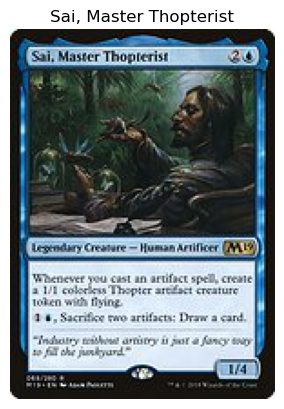

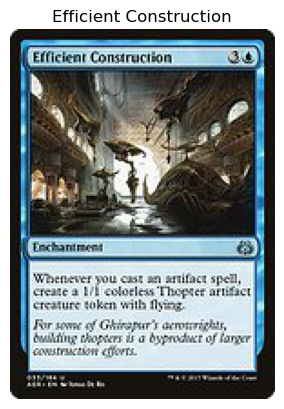

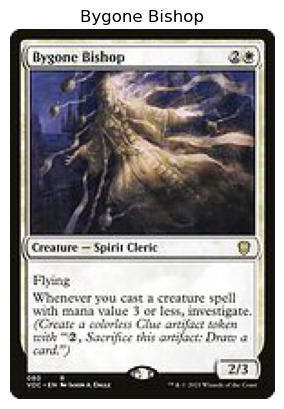

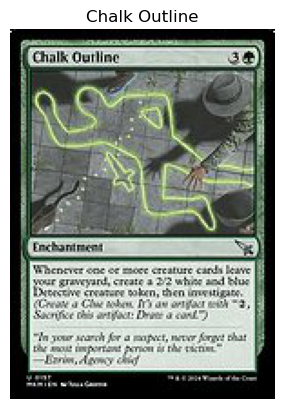

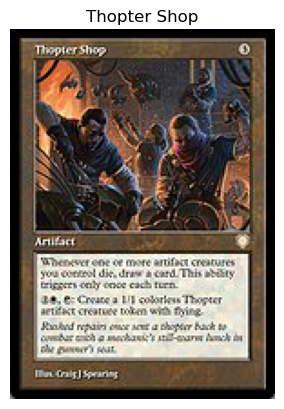

In [8]:
#cosine similarity function

def find_similar_cards_cosine(card_name, column_name, top=5):
    cosine_sim = cosine_similarity(list(df[column_name]), df[df.name==card_name][column_name].iloc[0].reshape(1, -1))
    topx=cosine_sim.flatten().argsort()[-top:][::-1]
    similar_cards=df.iloc[topx]
    for index, card in similar_cards.iterrows():
        image_url = card['image_uris']['small']
        response = requests.get(image_url)
        image = Image.open(BytesIO(response.content))
        plt.imshow(image)
        plt.axis('off')
        plt.title(card['name'])
        plt.show()

#find_similar_cards_cosine('Black Lotus', 'glove_embedding')
card_name='Sai, Master Thopterist'
column_name='glove_embedding'

find_similar_cards_cosine(card_name, column_name, top=5)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# 1. Separate features into different groups
numerical_features = df[['cmc', 'power', 'toughness', 'colorless_int', 'U_int', 'G_int', 'W_int', 'B_int', 'R_int', 'X_int', 'C_int', 'P_int', 'S_int']]
binary_features = df[list(df.columns[23:87])]
text_embeddings = df[list(df.columns[87:99])]

# 2. Normalize numerical features
scaler = StandardScaler()
normalized_numerical_features = scaler.fit_transform(numerical_features)

# 3. Reshape embedding features
reshaped_glove_embedding = np.array(df['glove_embedding'].tolist())
reshaped_glove_embedding_type_line = np.array(df['glove_embedding_type_line'].tolist())
reshaped_word2vec_embedding = np.array(df['word2vec_embedding'].tolist())
reshaped_word2vec_embedding_type_line = np.array(df['word2vec_embedding_type_line'].tolist())
reshaped_fasttext_embedding = np.array(df['fasttext_embedding'].tolist())
reshaped_fasttext_embedding_type_line = np.array(df['fasttext_embedding_type_line'].tolist())
reshaped_TFIDF= np.array(df['TFIDF'].tolist())
reshaped_TFIDF_type_line=np.array(df['TFIDF_type_line'].tolist())
reshaped_Bert_embeding=np.array(df['bert_embedding'].tolist())
reshaped_Bert_embedding_tye_line=np.array(df['bert_embedding_type_line'].tolist())
# 4. Concatenate features
X = np.concatenate([
    normalized_numerical_features, 
    binary_features.values, 
    reshaped_glove_embedding,
    reshaped_glove_embedding_type_line,
    reshaped_word2vec_embedding,
    reshaped_word2vec_embedding_type_line,
    reshaped_fasttext_embedding,
    reshaped_fasttext_embedding_type_line,
    reshaped_TFIDF,
    reshaped_TFIDF_type_line,
    reshaped_Bert_embeding,
    reshaped_Bert_embedding_tye_line
], axis=1)

# 5. Train KNN model
knn = NearestNeighbors(n_neighbors=5, algorithm='auto')
knn.fit(X)





NearestNeighbors()

c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


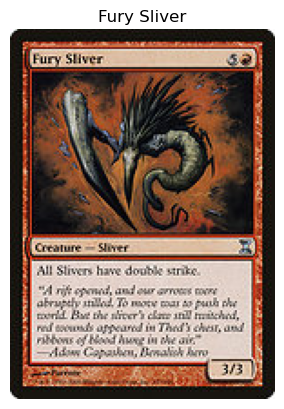

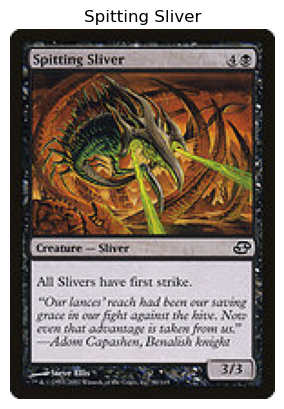

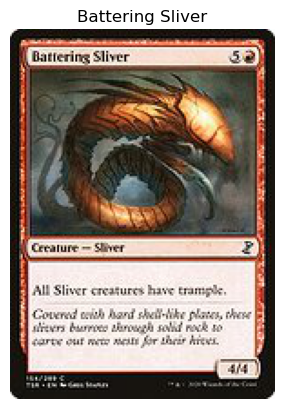

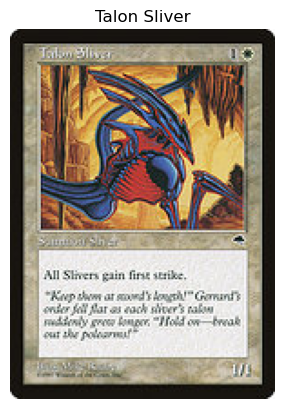

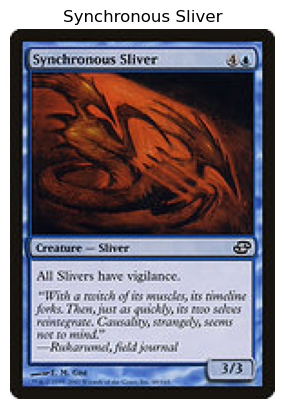

In [10]:
def get_features_for_card(card_name):
    # Extract features for the given card name
    card_numerical_features = df.loc[df['name'] == card_name, numerical_features.columns].values
    card_binary_features = df.loc[df['name'] == card_name, binary_features.columns].values
    card_text_embeddings = df.loc[df['name'] == card_name, text_embeddings.columns].values
    
    # Normalize numerical features
    card_numerical_features_normalized = scaler.transform(card_numerical_features)
    
    # Reshape embedding features
    reshaped_glove_embedding = np.array(df.loc[df['name'] == card_name, 'glove_embedding'].tolist())
    reshaped_glove_embedding_type_line = np.array(df.loc[df['name'] == card_name, 'glove_embedding_type_line'].tolist())
    reshaped_word2vec_embedding = np.array(df.loc[df['name'] == card_name, 'word2vec_embedding'].tolist())
    reshaped_word2vec_embedding_type_line = np.array(df.loc[df['name'] == card_name, 'word2vec_embedding_type_line'].tolist())
    reshaped_fasttext_embedding = np.array(df.loc[df['name'] == card_name, 'fasttext_embedding'].tolist())
    reshaped_fasttext_embedding_type_line = np.array(df.loc[df['name'] == card_name, 'fasttext_embedding_type_line'].tolist())
    reshaped_TFIDF = np.array(df.loc[df['name'] == card_name, 'TFIDF'].tolist())
    reshaped_TFIDF_type_line = np.array(df.loc[df['name'] == card_name, 'TFIDF_type_line'].tolist())
    reshaped_Bert_embedding = np.array(df.loc[df['name'] == card_name, 'bert_embedding'].tolist())
    reshaped_Bert_embedding_type_line = np.array(df.loc[df['name'] == card_name, 'bert_embedding_type_line'].tolist())

    # Concatenate features
    card_features = np.concatenate([
        card_numerical_features_normalized, 
        card_binary_features, 
        reshaped_glove_embedding,
        reshaped_glove_embedding_type_line,
        reshaped_word2vec_embedding,
        reshaped_word2vec_embedding_type_line,
        reshaped_fasttext_embedding,
        reshaped_fasttext_embedding_type_line,
        reshaped_TFIDF,
        reshaped_TFIDF_type_line,
        reshaped_Bert_embedding,
        reshaped_Bert_embedding_type_line
    ], axis=1)

    
    return card_features



def find_similar_cards(card_name, k=5):
    # Get features for the input card
    input_card_features = get_features_for_card(card_name)
    
    # Find most similar cards to the input card
    distances, indices = knn.kneighbors(input_card_features)
    
    # Output most similar cards
    similar_cards = df.iloc[indices[0]]
    
    # Display small images of similar cards
    for index, card in similar_cards.iterrows():
        image_url = card['image_uris']['small']
        response = requests.get(image_url)
        image = Image.open(BytesIO(response.content))
        plt.imshow(image)
        plt.axis('off')
        plt.title(card['name'])
        plt.show()

# Example usage:
input_card_name = "Fury Sliver"
find_similar_cards(input_card_name)


In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity

# Define custom distance function
def custom_distance(x1, x2, numeric_indices, embedding_indices):
    # Separate numerical features and text embeddings
    x1_numeric = x1[:, numeric_indices]
    x2_numeric = x2[:, numeric_indices]
    x1_embedding = x1[:, embedding_indices]
    x2_embedding = x2[:, embedding_indices]
    
    # Calculate distances for numerical features (using Euclidean distance)
    numeric_distance = euclidean(x1_numeric, x2_numeric)
    
    # Calculate similarities for text embeddings (using Cosine similarity)
    embedding_similarity = cosine_similarity(x1_embedding, x2_embedding)
    
    # Convert similarity to distance
    embedding_distance = 1 - embedding_similarity
    
    # Combine distances from numerical features and similarities from text embeddings
    combined_distance = numeric_distance + embedding_distance
    
    return combined_distance

# Define numerical feature indices and text embedding indices
numeric_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
embedding_indices = [13, 14, 15, 16, 17, 18]

# Create feature matrix X
X = np.concatenate([normalized_numerical_features, binary_features.values, text_embeddings.values], axis=1)

# Create k-NN model with custom distance function
knn = NearestNeighbors(n_neighbors=5, metric=custom_distance, metric_params={'numeric_indices': numeric_indices, 'embedding_indices': embedding_indices})

# Fit the model to the data
knn.fit(X)
